# DATA0006 Data Analytics with Python

The University of Melbourne

**Date: 30/03/2022**

**Group Members**:
- BONG LAU
- FAN LI
- GEORGE KOROVESIS

## 1. Introduction
This project is to extract, explore and analyze the relationship of energy demand and pricing category with weather data. The objective of this project is to develop two models which can predict the maximum half-hourly energy demand and pricing category for a day based on some weather data. Hopefully these models can help energy companies understand plan for future usage, and help businesses plan when to conduct energy-intensive operations.

## 2. Requirements and Getting Started

### 2.1. Data Sets Provided

#### 2.1.1. Energy Demand Data (CSV format)

* Date/time (in half-hour interval)
* Energy demand
* Price category (LOW, MEDIUM, HIGH, EXTREME)

#### 2.1.2. Weather Data (CSV format)

* Date
* Minimum temperature (°C)
* Maximum temperature (°C)
* Rainfall (mm)
* Evaporation (mm)
* Sunshine (hours)
* Direction of maximum wind gust 
* Speed of maximum wind gust (km/h)
* Time of maximum wind gust
* 9am Temperature (°C)
* 9am relative humidity (%)
* 9am cloud amount (oktas)
* 9am wind direction
* 9am wind speed (km/h)
* 9am MSL pressure (hPa)
* 3pm Temperature (°C)
* 3pm relative humidity (%)
* 3pm cloud amount (oktas)
* 3pm wind direction
* 3pm wind speed (km/h)
* 3pm MSL pressure (hPa)

### 2.2. Programming Environment

* Jupyter Notebook
* Python 3.8
* Libraries
 - import pandas as pd
 - from sklearn.metrics import normalized_mutual_info_score
 - from sklearn.feature_selection import mutual_info_classif as mi
 - from sklearn.tree import DecisionTreeClassifier
 - from sklearn import tree, neighbors, preprocessing
 - from sklearn.model_selection import train_test_split, KFold
 - from sklearn import linear_model
 - from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
 - import matplotlib.pyplot as plt

## 3. Data Wrangling and Aggregation

### 3.1 Data Aggregation - Obtain Daily Maximum

As the models are to predict the maximum half-hourly energy demand and pricing category for a day, we need to obtain the daily maximums from the given data set which contains half-hourly data.  This is done by splitting the date/time into separate date and time, and use the Pandas 'groupby' method on date and Pandas 'agg' method to obtain the maximum data within a day.  The pricing category is in string and thus an ordered category data type needs to be defined to calculate the maximum.

### 3.2 Data Aggregation - Combine Energy and Weather Data

With daily maximum energy data in place, an inner join of the energy data with the weather data (which is already daily) gives a single dataframe/CSV file of energy and weather data.

### 3.3 Data Augmentation - Date Derived Variables

It is stipulated that the models may depend on dates in some way.  So these variables are added to the data set based on the date:
- Month
- Day of week
- Weekend


In [1]:
'''
This program merges 2 data sets of energy data and weather data.

1. Reads 2 data sets:
    price_demand_data.csv
        half-hourly energy demand and price category
    weather_data.csv
        daily weather readings
2. Calculate the maximum half-hourly energy demand and maximum price category for each day
3. Merge the result with daily weather readings
4. Add the date-derived variables 'Month', 'Weekday', 'Weekend'
5. Write result to daily_price_demand_weather.csv
'''
import pandas as pd

# create a category type for PRICECATEGORY so as to define what is the maximum price category
price_categories_dtype = pd.CategoricalDtype(categories = ["LOW","MEDIUM","HIGH","EXTREME"], ordered=True)

# read data sets
price_demand = pd.read_csv('price_demand_data.csv', 
    dtype = {'PRICECATEGORY': price_categories_dtype},
    parse_dates=['SETTLEMENTDATE'], dayfirst=True)

weather_data = pd.read_csv('weather_data.csv',
    index_col = 'Date', parse_dates=['Date'], dayfirst=True)

# extract the date only, strip time information for later 'groupby'
price_demand['Date'] = price_demand['SETTLEMENTDATE'].dt.date

# obtain the max half-hourly energy demand and max price category for each day
# this was clarified by instructor Chris Ewan (vs the alternative interpretation of daily energy demand - aggregate function would have been 'sum')
max_demand = price_demand.groupby('Date').agg({'TOTALDEMAND': "max", 'PRICECATEGORY': "max"})

# merge 2 data sets
df = pd.merge(max_demand, weather_data, left_index=True, right_index=True)

# add the variable 'Month'
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday
df['Weekend'] = df['Weekday'].map(lambda x: x in [0,6]) # weekend is a Saturday or Sunday

# write result
df.to_csv('daily_price_demand_weather.csv')

### 3.4 Data Wrangling - Non-Numeric Variables

As some algorithms (Pearson correlation, linear regression) to be used later would require numeric data, non-numeric variables would need to be converted to numeric.

### 3.4.1 Wind Directions

The wind directions ('N', 'NNE', 'NE' etc.) are converted to the their bearing values (0, 22.5, 45, etc.)
Null wind direction is converted to -1.

### 3.4.2 Calm Wind

The word 'Calm' is used in the data and this is converted to 0.

### 3.4.3 Time

Time is converted to number of minutes.

### 3.5 Data Wrangling - Drop Null Data

Any rows with null data is dropped using the 'dropna' method.

In [2]:
'''
This program cleans the dataset.

Input: daily_price_demand_weather.csv

1. Convert directions to numeric values
2. Change 'calm' wind speed to 0
3. Convert time to numeric values
4. Drop rows with null values 

Output: daily_price_demand_weather_clean.csv
'''

import pandas as pd

df = pd.read_csv('daily_price_demand_weather.csv', index_col = 'Date')

# to perform linear regression, categorical variables have to be converted to numbers
directions = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
direction_map = {directions[i]:i*22.5 for i in range(len(directions))}
df['Direction of maximum wind gust '] = df['Direction of maximum wind gust '].map(direction_map)
df['9am wind direction'] = df['9am wind direction'].map(direction_map)
df['3pm wind direction'] = df['3pm wind direction'].map(direction_map)

# blank values have to be assigned a numeric value 
df.loc[pd.isna(df['9am wind direction']), '9am wind direction'] = -1
df.loc[pd.isna(df['3pm wind direction']), '3pm wind direction'] = -1

# 'calm' wind speed is 0
df.loc[df['9am wind speed (km/h)'].str.upper()=='CALM', '9am wind speed (km/h)'] = 0
df.loc[df['3pm wind speed (km/h)'].str.upper()=='CALM', '3pm wind speed (km/h)'] = 0

# convert time in "hh:mm" format to number of minutes
def num_minutes(timestring):
    if type(timestring) == str and ':' in timestring:
        hour, minute = str(timestring).split(':')
        return int(hour)*60 + int(minute)

df['Time of maximum wind gust'] = df['Time of maximum wind gust'].apply(num_minutes)

# drop rows with null values
df = df.dropna()

print(df)
# write result
df.to_csv('daily_price_demand_weather_clean.csv')

            TOTALDEMAND PRICECATEGORY  Minimum temperature (°C)  \
Date                                                              
2021-01-01      5019.64           LOW                      15.6   
2021-01-02      4964.35           LOW                      18.4   
2021-01-03      4503.31           LOW                      17.0   
2021-01-04      4764.18           LOW                      16.0   
2021-01-05      4800.64           LOW                      15.9   
...                 ...           ...                       ...   
2021-08-26      7126.76       EXTREME                       5.5   
2021-08-27      6769.89       EXTREME                       4.6   
2021-08-28      5716.32        MEDIUM                       5.3   
2021-08-29      6227.89       EXTREME                       9.1   
2021-08-30      6072.91          HIGH                       6.4   

            Maximum temperature (°C)  Rainfall (mm)  Evaporation (mm)  \
Date                                                   

## 4. Model Development

Two models are to be developed:
1. Maximum half-hourly energy demand
2. Maximum pricing category

Energy demand is continuous data. So linear regression model would be used.

Pricing category is discrete data. So decision tree classification model or knn classification model can be used.

But before developing any models, we need to select the features/variables to be included in the models.

### 4.1. Feature Selection using Correlation

We select the features by examining their correlation with the target variable and picking the most correlated ones.  Two correlation algorithms are used - Pearson correlation and mutual information.

We also compute the pair-wise correlation between the features so as to detect high correlation between certain features and only pick a representative one among them to avoid the 'curse of dimensionality'.

### 4.1.1. Feature Selection - Pearson Correlation

For the continuous dependent variable of energy demand, we apply Pearson correlation with all independent variables.  The variables of top correlations are:

| Variable | Correlation |
|:---|---:|
| Month                                | 0.566494 |
| Minimum temperature (°C)             | 0.482917 |
| 9am Temperature (°C)                 | 0.375774 | 
| 9am wind direction                   | 0.326448 | 
| 3pm Temperature (°C)                 | 0.307012 |
| Maximum temperature (°C)             | 0.278702 |
| Weekday                              | 0.248948 |
| Evaporation (mm)                     | 0.240583 |

They are then examined with regard to the correlation between them (see the output of pairwise correlations).  It is found that 'Minimum temperature' highly correlate with '9am Temperature' (0.91) while 'Maximum temperature' highly correlate with '3pm temperature' (0.97).  It is determined to drop 'Minimum temperature' and 'Maximum temperature'.

### 4.1.2. Feature Selection - Mutual Information

For the discrete dependent variable of price category, we apply mutual information correlation with all independent variables. The variables of top correlations are:

| Variable | Correlation |
|:---|---:|
| Maximum temperature (°C)             | 0.314163| 
| 3pm Temperature (°C)                 | 0.296882| 
| Minimum temperature (°C)             | 0.293136| 
| Month                                | 0.282424| 
| 9am Temperature (°C)                 | 0.280045| 
| Evaporation (mm)                     | 0.255480| 

They are then examined with regard to the correlation between them (see the output of pairwise correlations).  The correlations between them are not high (<=0.6) and thus they are all accepted.

In [3]:
'''
This program computes the pairwise Pearson correlation and mutual information between the variables of energy and weather data
The objective is to provide insight on selecting variables that correlate most and be included in energy prediction models.
Input: daily_price_demand_weather_clean.csv
Output:
    daily_price_demand_weather_pearson.csv (for Pearson correlation)
    daily_price_demand_weather_mi.csv (for mutual information)  
'''

import pandas as pd
from sklearn.metrics import normalized_mutual_info_score

df = pd.read_csv('daily_price_demand_weather_clean.csv')

##########################
# compute pairwise Pearson correlation for numeric variables
df_corr = df.corr(method='pearson')
df_corr.to_csv('daily_price_demand_weather_pearson.csv')

# sort the correlations with energy demand to facilitate feature selection
print("Pearson correlation with energy demand:")
print(df_corr['TOTALDEMAND'].abs().sort_values(ascending=False))
print()


##########################
# compute pairwise mutual information

# continuous variables need to be binned before computing mutual information
n_bins = 24
vars_to_bin = {
    "Minimum temperature (°C)",
    "Maximum temperature (°C)",
    "Rainfall (mm)",
    "Evaporation (mm)",
    "Sunshine (hours)",
    "Speed of maximum wind gust (km/h)",
    "Time of maximum wind gust",
    "9am Temperature (°C)",
    "9am relative humidity (%)",
    "9am wind speed (km/h)",
    "9am MSL pressure (hPa)",
    "3pm Temperature (°C)",
    "3pm relative humidity (%)",
    "3pm wind speed (km/h)",
    "3pm MSL pressure (hPa)"
}
for var in vars_to_bin:
    df[var] = pd.qcut(df[var], q=n_bins, duplicates="drop").cat.codes

# first, gather the list of variables to compute pairwise mutual information
vars = df.columns.tolist()
vars.remove("Date")
vars.remove("TOTALDEMAND")

df_mi = pd.DataFrame()
for i in range(len(vars)):
    for j in range(len(vars)):
        if j >= i:
            break
        df_mi.loc[vars[i], vars[j]] = normalized_mutual_info_score(df[vars[i]], df[vars[j]], average_method='min')

df_mi.to_csv("daily_price_demand_weather_mi.csv")

# sort the correlations with price category to facilitate feature selection
print("Mutual information with price category:")
print(df_mi['PRICECATEGORY'].abs().sort_values(ascending=False))
print()


Pearson correlation with energy demand:
TOTALDEMAND                          1.000000
Month                                0.566494
Minimum temperature (°C)             0.482917
9am Temperature (°C)                 0.375774
9am wind direction                   0.326448
3pm Temperature (°C)                 0.307012
Maximum temperature (°C)             0.278702
Weekday                              0.248948
Evaporation (mm)                     0.240583
Time of maximum wind gust            0.188241
3pm wind direction                   0.168314
Sunshine (hours)                     0.161514
9am cloud amount (oktas)             0.149851
9am wind speed (km/h)                0.138916
Speed of maximum wind gust (km/h)    0.109156
9am relative humidity (%)            0.086018
Weekend                              0.085065
3pm cloud amount (oktas)             0.083233
Direction of maximum wind gust       0.081472
Rainfall (mm)                        0.070180
3pm relative humidity (%)            0.0

C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(ms

Mutual information with price category:
Maximum temperature (°C)             0.314163
3pm Temperature (°C)                 0.296882
Minimum temperature (°C)             0.293136
Month                                0.282424
9am Temperature (°C)                 0.280045
Evaporation (mm)                     0.255480
9am MSL pressure (hPa)               0.170906
Sunshine (hours)                     0.162880
3pm relative humidity (%)            0.159280
9am wind direction                   0.153679
Time of maximum wind gust            0.153183
9am relative humidity (%)            0.151437
Speed of maximum wind gust (km/h)    0.130348
Direction of maximum wind gust       0.130308
3pm wind direction                   0.129989
3pm MSL pressure (hPa)               0.117206
3pm wind speed (km/h)                0.099528
3pm cloud amount (oktas)             0.084350
Rainfall (mm)                        0.068993
9am cloud amount (oktas)             0.062195
9am wind speed (km/h)                0.0

C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\carlisle\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(ms

### 4.2. Building the Model for Energy Demand - Linear Regression

Using the features selected above (Section 4.1.1), a linear regression model is built with 80% of data set as training data and 20% as testing data.  The result is as follows:

`Coefficients:
 'Month': 201.1913,
 'Weekday': -95.7112,
 'Evaporation (mm)': 32.9096,
 '9am Temperature (°C)': -8.7438,
 '9am wind direction': -1.3716,
 '3pm Temperature (°C)': 12.859
Intercept: 5425.1093
`

**r2: 0.5785**

In [4]:
'''
This program performs linear regression on maximum half-hourly energy demand against selective daily weather variables.

Input: daily_price_demand_weather_clean.csv
Output: coefficients, intercept, r2 of the linear regression
'''
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('daily_price_demand_weather_clean.csv')

use_all_features = False

if use_all_features:
    featurenames = list(pd.read_csv('weather_data.csv').columns)
    featurenames.remove('Date')
    print(featurenames)
else:
    # variables(features) selected to be used, based on correlation result
    '''
    Top correlations:
    Month                                0.566494
    Minimum temperature (°C)             0.482917
    9am Temperature (°C)                 0.375774
    9am wind direction                   0.326448
    3pm Temperature (°C)                 0.307012
    Maximum temperature (°C)             0.278702
    Weekday                              0.248948
    Evaporation (mm)                     0.240583
    '''
    featurenames = [
        'Month',
        'Weekday', 
        #'Minimum temperature (°C)', # removed due to high correlation with 9am temperature
        #'Maximum temperature (°C)', # removed due to high correlation with 3pm temperature
        'Evaporation (mm)',
        '9am Temperature (°C)', 
        '9am wind direction', 
        '3pm Temperature (°C)', 
        ]

features = df[featurenames]
classlabel = df['TOTALDEMAND']

features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size= 0.8, test_size = 0.2,  random_state=3)
lm = linear_model.LinearRegression()
model = lm.fit(features_train, class_train)

# coefficents and intercept
print("Coefficients: ")
display(dict(zip(featurenames, lm.coef_.round(4))))
print(f"Intercept: {lm.intercept_:.4f}") 

# r2 value
r2_test = lm.score(features_test, class_test)
print(f"r2: {r2_test:.4f}")


Coefficients: 


{'Month': 201.1913,
 'Weekday': -95.7112,
 'Evaporation (mm)': 32.9096,
 '9am Temperature (°C)': -8.7438,
 '9am wind direction': -1.3716,
 '3pm Temperature (°C)': 12.859}

Intercept: 5425.1093
r2: 0.5785


### 4.2.1. Evaluation

From the r2 value, we can tell that it is not an obvious linear regression relationship. Then we draw the scatter plot between the energy demand and the maximum temperature as follows:

**Figure 1**: The relationship between the maximum daily energy usage and the maximum temperature
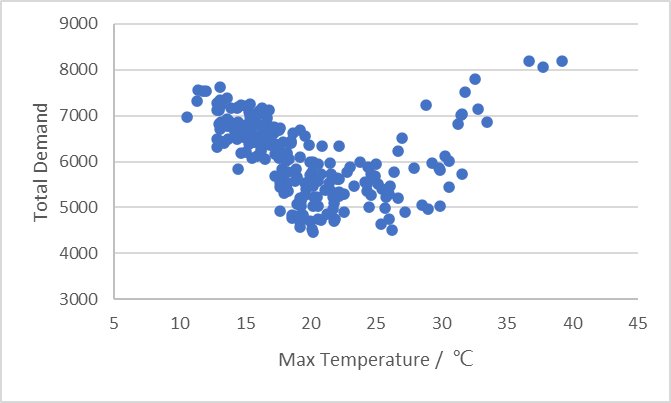

From figure 1, we can tell that the energy demand is lowest between 20 ℃ and 25 ℃. This is reasonable because this is the most comfortable temperature range. People will need heater in colder days and air conditioner in hotter days, which result in an increase of the energy usage.

**Figure 2**: Residuals plotting (left) and their distribution histogram (right).
<img src="Figure_Residual_LinearRegr.png">

Figure 2 shows the residual distribution of the Train (blue) and Test (green) datasets. The Test points distribution around the horizontal axis is not well dispresed which indicates that the linear model is not very appropriate for our data.

### 4.3. Building the Model for Price Category - Decision Tree Classification

Using the features selected above (Section 4.1.2), a decision tree classification model is built with 80% of data set as training data and 20% as testing data, and a maximum depth of 3.  The result is as follows:

**Accuracy: 0.5417**


Accuracy: 0.5417


[Text(697.5, 951.3000000000001, 'Month <= 3.5\nentropy = 1.972\nsamples = 189\nvalue = [47, 51, 33, 58]'),
 Text(348.75, 679.5, 'Maximum temperature (°C) <= 31.05\nentropy = 1.46\nsamples = 70\nvalue = [1, 7, 32, 30]'),
 Text(174.375, 407.70000000000005, 'Month <= 2.5\nentropy = 1.372\nsamples = 62\nvalue = [1, 4, 32, 25]'),
 Text(87.1875, 135.89999999999998, 'entropy = 1.064\nsamples = 40\nvalue = [0, 1, 26, 13]'),
 Text(261.5625, 135.89999999999998, 'entropy = 1.583\nsamples = 22\nvalue = [1, 3, 6, 12]'),
 Text(523.125, 407.70000000000005, 'Maximum temperature (°C) <= 37.25\nentropy = 0.954\nsamples = 8\nvalue = [0, 3, 0, 5]'),
 Text(435.9375, 135.89999999999998, 'entropy = 0.65\nsamples = 6\nvalue = [0, 1, 0, 5]'),
 Text(610.3125, 135.89999999999998, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2, 0, 0]'),
 Text(1046.25, 679.5, 'Maximum temperature (°C) <= 18.9\nentropy = 1.61\nsamples = 119\nvalue = [46, 44, 1, 28]'),
 Text(871.875, 407.70000000000005, 'Evaporation (mm) <= 4.1\nentropy

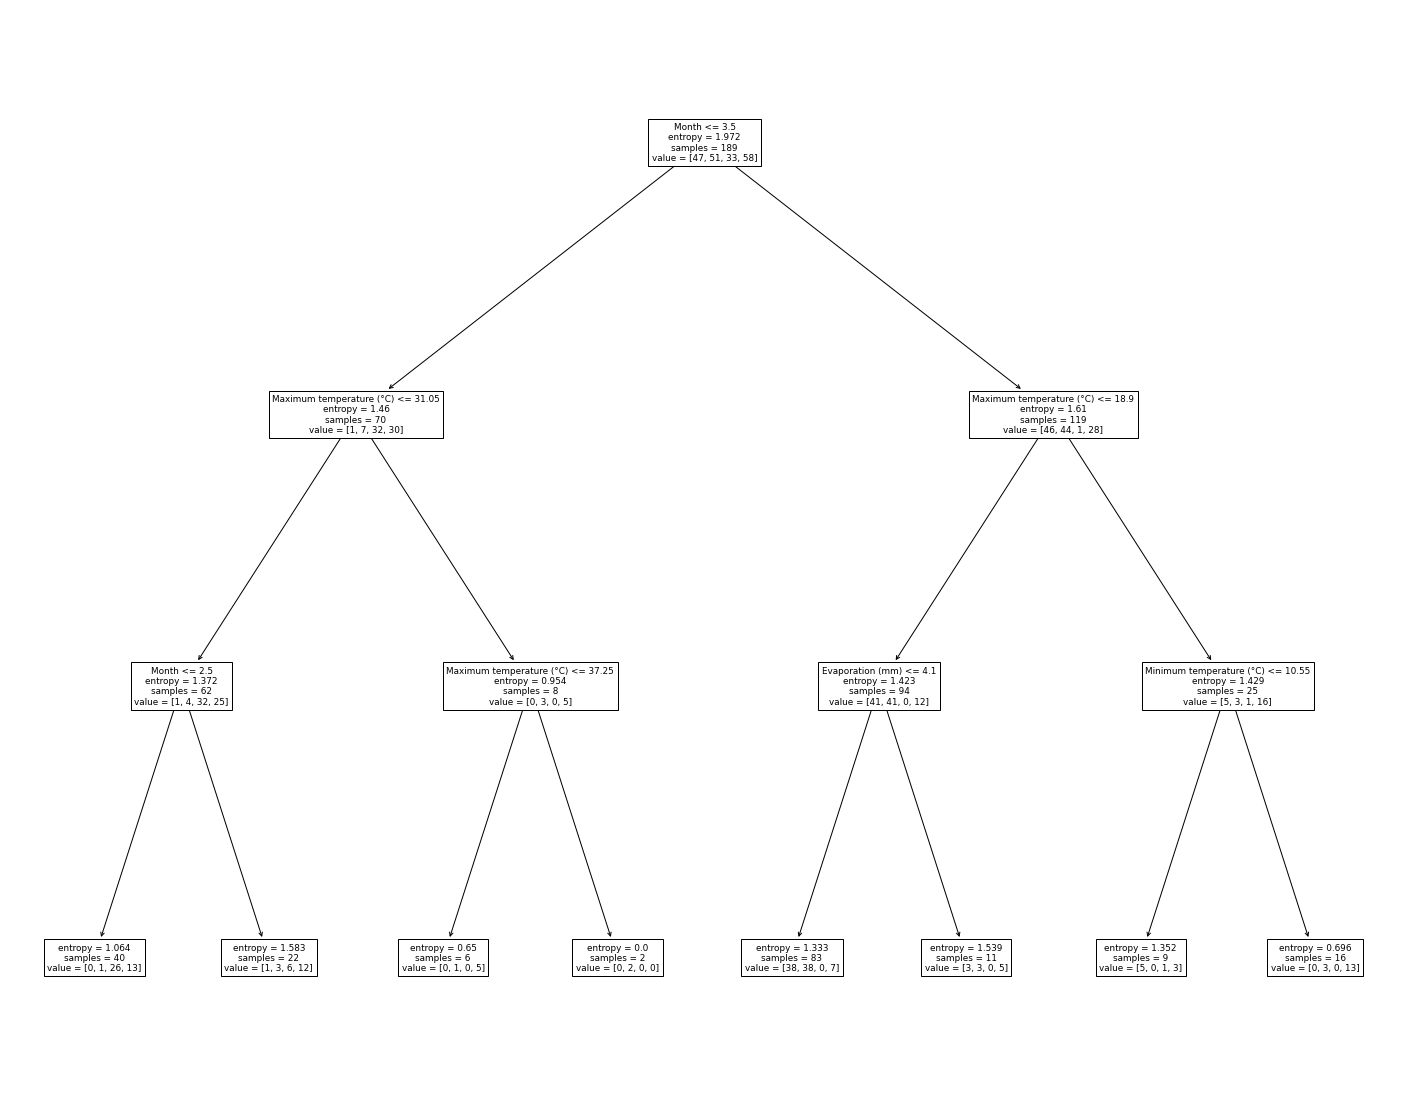

In [5]:
'''
This program performs decision tree classification of maximum price category using selective daily weather variables.

Input: daily_price_demand_weather_clean.csv
Output: decision tree, accuracy score of the model
'''
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt

df = pd.read_csv('daily_price_demand_weather_clean.csv')

use_all_features = False

if use_all_features:
    featurenames = list(pd.read_csv('weather_data.csv').columns)
    featurenames.remove('Date')
    print(featurenames)
else:
    # variables (features) selected to be used, based on correlation result
    '''
    Top correlations:
    Maximum temperature (°C)             0.314163
    3pm Temperature (°C)                 0.296882
    Minimum temperature (°C)             0.293136
    Month                                0.282424
    9am Temperature (°C)                 0.280045
    Evaporation (mm)                     0.255480
    '''
    featurenames = [
        'Month',
        'Minimum temperature (°C)', 
        'Maximum temperature (°C)', 
        'Evaporation (mm)', 
        '9am Temperature (°C)', 
        '3pm Temperature (°C)', 
    ]

features = df[featurenames]
classlabel = df['PRICECATEGORY']

features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size=0.8, test_size=0.2, random_state=3)

dt = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=3)
dt.fit(features_train, class_train)

predictions = dt.predict(features_test)

print(f"Accuracy: {accuracy_score(class_test, predictions):.4f}")

# Plot the decision tree
fig = plt.figure(figsize=(25, 20))
tree.plot_tree(dt, feature_names = featurenames)

#### 4.3.1. Evaluation

1. According to the decision tree for predicting price category, the top level node is testing against the month (Month <= 3.5). This implies that the **month** is the most valuable variable in predicting price - summer months (January to March) are usually of lower price, while the other months (April onwards, until August as available in the given data set) are usually of higher price.

2. To ascertain the true performance of the decision tree model, the model is run through the K-Fold cross-validation algorithm (with k = 10) .  The result is an **average accuracy of 0.38**.


In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import KFold

df = pd.read_csv('daily_price_demand_weather_clean.csv')

if use_all_features:
    featurenames = list(pd.read_csv('weather_data.csv').columns)
    featurenames.remove('Date')
    print(featurenames)
else:
    # variables (features) selected to be used, based on correlation result
    '''
    Top correlations:
    Maximum temperature (°C)             0.314163
    3pm Temperature (°C)                 0.296882
    Minimum temperature (°C)             0.293136
    Month                                0.282424
    9am Temperature (°C)                 0.280045
    Evaporation (mm)                     0.255480
    '''
    featurenames = [
        'Month',
        'Minimum temperature (°C)', 
        'Maximum temperature (°C)', 
        'Evaporation (mm)', 
        '9am Temperature (°C)', 
        '3pm Temperature (°C)', 
    ]

features = df[featurenames]
classlabel = df['PRICECATEGORY']
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=3)
acc_scores = []

for train_index, test_index in kf.split(df):

    features_train = features.iloc[train_index, :]
    features_test = features.iloc[test_index, :]

    class_train = classlabel[train_index]
    class_test = classlabel[test_index]
    
    dt = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=3)
    dt.fit(features_train, class_train)

    predictions = dt.predict(features_test)

    score = accuracy_score(class_test, predictions)
    acc_scores.append(score)

avg_acc_score = sum(acc_scores)/k
print(f"Average accuracy: {avg_acc_score:.4f}")
print(f"Minimum accuracy: {min(acc_scores):.4f}")
print(f"Maximum accuracy: {max(acc_scores):.4f}")
print(f"Accuracy score: {acc_scores}")


Average accuracy: 0.3797
Minimum accuracy: 0.2609
Maximum accuracy: 0.5417
Accuracy score: [0.3333333333333333, 0.5416666666666666, 0.375, 0.3333333333333333, 0.2916666666666667, 0.375, 0.4166666666666667, 0.2608695652173913, 0.34782608695652173, 0.5217391304347826]


### 4.4. Building the Model for Price Category - KNN

Using the features selected above (Section 4.1.2), a KNN model is built with 80% of data set as training data and 20% as testing data, and k = 5.  The result is as follows:

**Accuracy: 0.5**


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# A model which predicts the maximum daily price category based on the provided weather data.
# KNN model

df = pd.read_csv('daily_price_demand_weather_clean.csv')

if use_all_features:
    featurenames = list(pd.read_csv('weather_data.csv').columns)
    featurenames.remove('Date')
    print(featurenames)
else:
    # variables (features) selected to be used, based on correlation result
    '''
    Top correlations:
    Maximum temperature (°C)             0.314163
    3pm Temperature (°C)                 0.296882
    Minimum temperature (°C)             0.293136
    Month                                0.282424
    9am Temperature (°C)                 0.280045
    Evaporation (mm)                     0.255480
    '''
    featurenames = [
        'Month',
        'Minimum temperature (°C)', 
        'Maximum temperature (°C)', 
        'Evaporation (mm)', 
        '9am Temperature (°C)', 
        '3pm Temperature (°C)', 
    ]

features = df[featurenames]
classlabel = df['PRICECATEGORY']

features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size=0.8, test_size=0.2, random_state=3)

# normalise the data to have 0 mean and unit variance using the library functions.
# This will help for later computation of distances between instances
scaler = preprocessing.StandardScaler().fit(features_train)
features_train=scaler.transform(features_train)
features_test=scaler.transform(features_test)

knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(features_train, class_train)

y_pred = knn.predict(features_test)
score = accuracy_score(class_test, y_pred)
print(score)

0.5


#### 4.4.1. Evaluation

To ascertain the true performance of the KNN model, the model is run through the K-Fold cross-validation algorithm (with k = 10) .  The result is an **average accuracy of 0.45**.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import KFold

df = pd.read_csv('daily_price_demand_weather_clean.csv')

if use_all_features:
    featurenames = list(pd.read_csv('weather_data.csv').columns)
    featurenames.remove('Date')
    print(featurenames)
else:
    # variables (features) selected to be used, based on correlation result
    '''
    Top correlations:
    Maximum temperature (°C)             0.314163
    3pm Temperature (°C)                 0.296882
    Minimum temperature (°C)             0.293136
    Month                                0.282424
    9am Temperature (°C)                 0.280045
    Evaporation (mm)                     0.255480
    '''
    featurenames = [
        'Month',
        'Minimum temperature (°C)', 
        'Maximum temperature (°C)', 
        'Evaporation (mm)', 
        '9am Temperature (°C)', 
        '3pm Temperature (°C)', 
    ]

features = df[featurenames]
classlabel = df['PRICECATEGORY']

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=3)
acc_scores = []

for train_index, test_index in kf.split(df):

    features_train = features.iloc[train_index, :]
    features_test = features.iloc[test_index, :]

    class_train = classlabel[train_index]
    class_test = classlabel[test_index]

    scaler = preprocessing.StandardScaler().fit(features_train)
    features_train = scaler.transform(features_train)
    features_test = scaler.transform(features_test)

    knn = neighbors.KNeighborsClassifier(n_neighbors=5)
    knn.fit(features_train, class_train)

    predictions = knn.predict(features_test)
    score = accuracy_score(class_test, predictions)
    acc_scores.append(score)

avg_acc_score = sum(acc_scores)/k
print(f"Average accuracy: {avg_acc_score:.4f}")
print(f"Minimum accuracy: {min(acc_scores):.4f}")
print(f"Maximum accuracy: {max(acc_scores):.4f}")
print(f"Accuracy score: {acc_scores}")


Average accuracy: 0.4556
Minimum accuracy: 0.3043
Maximum accuracy: 0.5652
Accuracy score: [0.3333333333333333, 0.5416666666666666, 0.4583333333333333, 0.4166666666666667, 0.5416666666666666, 0.5, 0.4166666666666667, 0.4782608695652174, 0.5652173913043478, 0.30434782608695654]


## 5. Further Improvements

### 5.1. Feature Selection
We have used correlation to guide our selection of features to be included in the models.

To seek further improvement in feature selection to potentially improve the models, we can use chi-squared test to test whether the class label feature/dependent variable is really dependent on each of the feature/dependent variables in the weather data set.

Furthermore, PCA can be used to synthesize a few variables from the given weather data that should produce models that perform better, though the downside is that the synthesized variables are not easily comprehensible.

### 5.2 Energy Demand Model - Beyond Linear Regression

#### 5.2.1 Non-linear Regression
It is apparent that the relationship between energy demand and weather data (be it a single variable or combinations) is not linear.  We need some algorithms of non-linear regression to more accurately model the relationship.  

#### 5.2.2 Classification
Meanwhile, we can discretize the energy demand and build classification models. The following two programs build the decision tree model and KNN model respectively.

The key finding is that the finer the discretization, the less accurate is the model. And this is true for both classification methods.  This places a severe limitation on the usefulness of the models: if we want to have a more accurate prediction result, the range of energy demand is broader; we cannot give a more specific energy demand value while being accurate in the prediction.

Having said that, KNN model is better than decision tree in general for this dataset, with a higher accuracy score at the same level of discretization (number of bins).

number of bins = 4, accuracy score = 0.5556
number of bins = 5, accuracy score = 0.3750
number of bins = 6, accuracy score = 0.4028
number of bins = 8, accuracy score = 0.2778
number of bins = 10, accuracy score = 0.1806
number of bins = 20, accuracy score = 0.1806
number of bins = 25, accuracy score = 0.0417
number of bins = 50, accuracy score = 0.0278
number of bins = 100, accuracy score = 0.0000


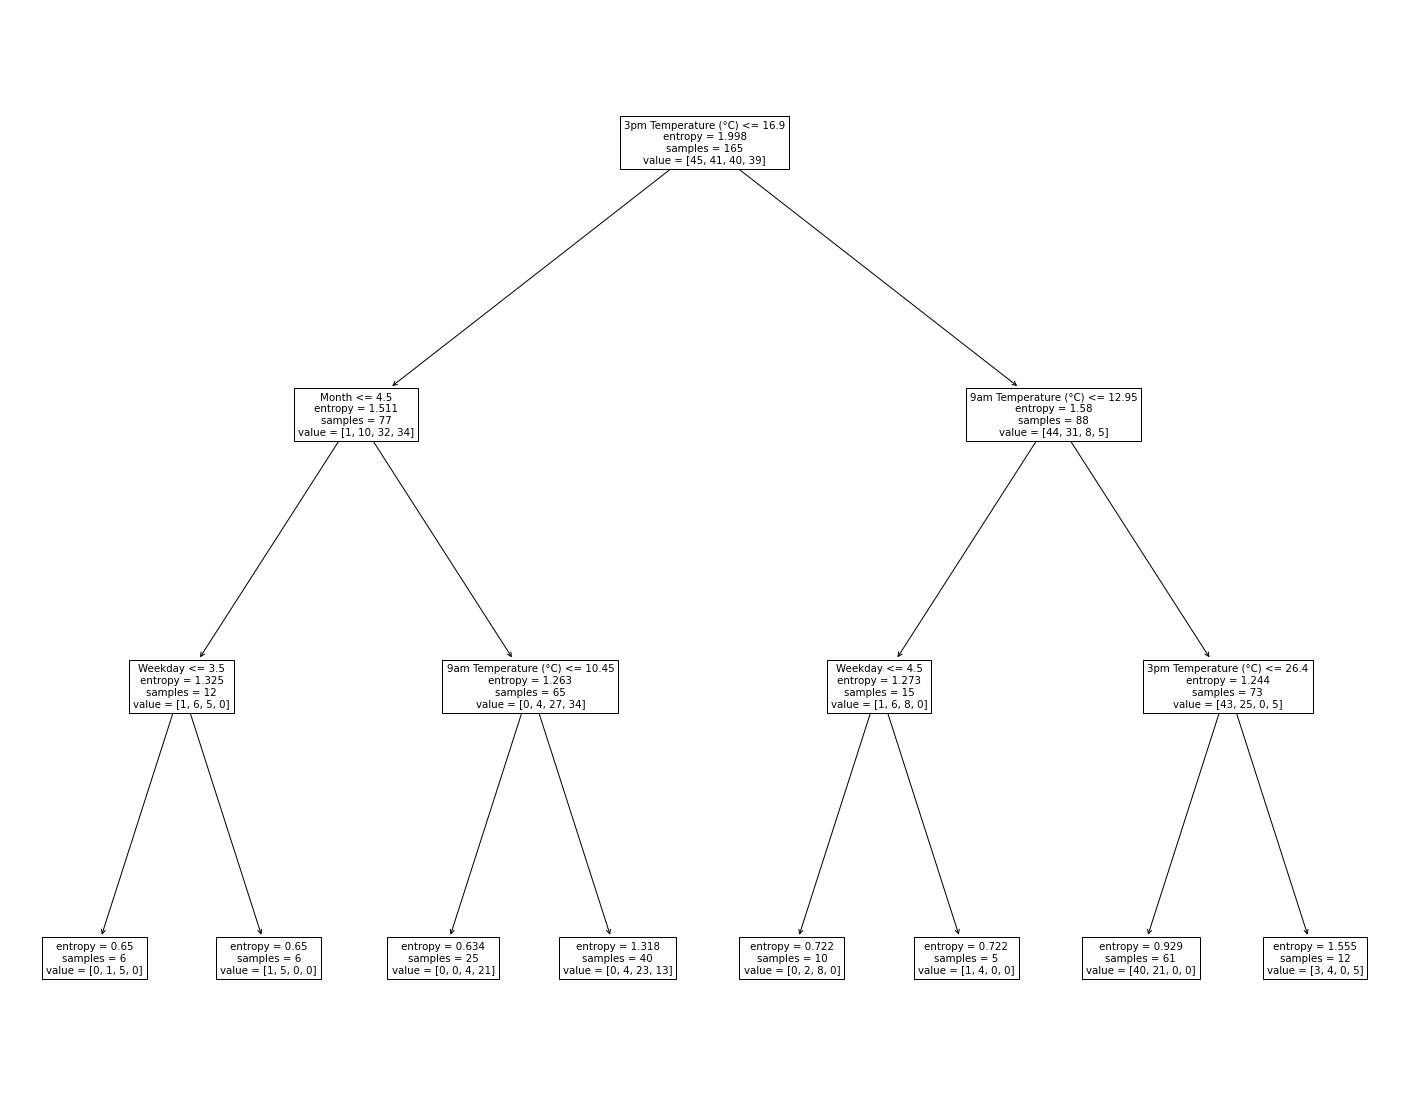

In [9]:
'''
This program performs decision tree classification of maximum half-hourly energy demand, with various discretization,
using selective daily weather variables.

Input: daily_price_demand_weather_clean.csv
Output: accuracy scores for different discretization (bins)
'''
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt

df = pd.read_csv('daily_price_demand_weather_clean.csv')

use_all_features = False

if use_all_features:
    featurenames = list(pd.read_csv('weather_data.csv').columns)
    featurenames.remove('Date')
    print(featurenames)
else:
    # variables(features) selected to be used, based on correlation result
    '''
    Top correlations:
    Month                                0.566494
    Minimum temperature (°C)             0.482917
    9am Temperature (°C)                 0.375774
    9am wind direction                   0.326448
    3pm Temperature (°C)                 0.307012
    Maximum temperature (°C)             0.278702
    Weekday                              0.248948
    Evaporation (mm)                     0.240583
    '''
    featurenames = [
        'Month',
        'Weekday', 
        #'Minimum temperature (°C)', # removed due to high correlation with 9am temperature
        #'Maximum temperature (°C)', # removed due to high correlation with 3pm temperature
        'Evaporation (mm)',
        '9am Temperature (°C)', 
        '9am wind direction', 
        '3pm Temperature (°C)', 
        ]
    
features = df[featurenames]

for n_bin in [4,5,6,8,10,20,25,50,100]:  
    classlabel = pd.qcut(df['TOTALDEMAND'], q=n_bin).cat.codes
    
    features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size=0.7, test_size=0.3, random_state=3)

    dt = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=3)
    dt.fit(features_train, class_train)

    predictions = dt.predict(features_test)
    print(f"number of bins = {n_bin}, accuracy score = {accuracy_score(class_test, predictions):.4f}")

    # Plot the decision tree
    if n_bin == 4:
        fig = plt.figure(figsize=(25, 20))
        tree.plot_tree(dt, feature_names = featurenames)
    

In [10]:
'''
This program performs KNN classification of maximum half-hourly energy demand, with various discretization,
using selective daily weather variables.

Input: daily_price_demand_weather_clean.csv
Output: accuracy scores for different discretization (bins)
'''
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

df = pd.read_csv('daily_price_demand_weather_clean.csv')

use_all_features = False

if use_all_features:
    featurenames = list(pd.read_csv('weather_data.csv').columns)
    featurenames.remove('Date')
    print(featurenames)
else:
    # variables(features) selected to be used, based on correlation result
    '''
    Top correlations:
    Month                                0.566494
    Minimum temperature (°C)             0.482917
    9am Temperature (°C)                 0.375774
    9am wind direction                   0.326448
    3pm Temperature (°C)                 0.307012
    Maximum temperature (°C)             0.278702
    Weekday                              0.248948
    Evaporation (mm)                     0.240583
    '''
    featurenames = [
        'Month',
        'Weekday', 
        #'Minimum temperature (°C)', # removed due to high correlation with 9am temperature
        #'Maximum temperature (°C)', # removed due to high correlation with 3pm temperature
        'Evaporation (mm)',
        '9am Temperature (°C)', 
        '9am wind direction', 
        '3pm Temperature (°C)', 
        ]
    
features = df[featurenames]

for n_bin in [4,5,6,8,10,20,25,50,100]:  
    classlabel = pd.qcut(df['TOTALDEMAND'], q=n_bin).cat.codes
    
    features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size=0.8, test_size=0.2, random_state=3)

    # normalise the data to have 0 mean and unit variance using the library functions.
    # This will help for later computation of distances between instances
    scaler = preprocessing.StandardScaler().fit(features_train)
    features_train=scaler.transform(features_train)
    features_test=scaler.transform(features_test)

    knn = neighbors.KNeighborsClassifier(n_neighbors=5)
    knn.fit(features_train, class_train)

    y_pred = knn.predict(features_test)
    score = accuracy_score(class_test, y_pred)

    print(f"number of bins = {n_bin}, accuracy score = {score:.4f}")
    

number of bins = 4, accuracy score = 0.7917
number of bins = 5, accuracy score = 0.6667
number of bins = 6, accuracy score = 0.6250
number of bins = 8, accuracy score = 0.5208
number of bins = 10, accuracy score = 0.4583
number of bins = 20, accuracy score = 0.2083
number of bins = 25, accuracy score = 0.2083
number of bins = 50, accuracy score = 0.0625
number of bins = 100, accuracy score = 0.0625
